# Дообучение модели mT5 для суммаризации текстов на основе датасета новостей с сайта Lenta.ru

mT5 — предобученный мультилингвальный Transformer для 101 языков. mT5 является расширением модели Text-to-Text Transfer Transformer (T5). Архитектуру T5 разработали исследователи из Google AI. mT5 обучался на корпусе веб-страниц из Common Crawl на 101 языках, — mC4.

Архитектура модели и процедура обучения mT5 схожа с архитектурой и обучением классической T5 модели. mT5 основывается на версии “T5.1.1” модели T5, в которой используют GeGLU нелинейность и предобучают на неразмеченных данных без использования dropout. Данные на разных языках семплировали так, что бы можно было регулировать баланс между редкими и популярными языками веб-страниц. Для этого вычисляли вероятность семплинга текста на определенном языке.

## Запускаем установку необходимых библиотек

In [ ]:
!pip install transformers transformers[torch] datasets evaluate rouge_score sentencepiece
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.6 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3

## Чтобы библиотеки заработали, обязательно перезапускаем среду выполнения
После этого строки выше повторно не запускаем, выполняем код ниже.

# Summarization

Summarization creates a shorter version of a document or an article that captures all the important information. Along with translation, it is another example of a task that can be formulated as a sequence-to-sequence task. Summarization can be:

- Extractive: extract the most relevant information from a document.
- Abstractive: generate new text that captures the most relevant information.

## Load Lenta dataset

Загрузим и подготовим датасет из новостных статей и резюме с сайта Lenta.ru

In [ ]:
import pandas as pd
# df = pd.read_csv('lenta.csv', index_col=None)
df = pd.read_csv('http://fotolx.ru/temp/DS/lenta.csv', index_col=None)

In [ ]:
df['Description'].replace(r'\s+|\\n', ' ', regex=True, inplace=True)
# df['Description']

In [ ]:
from datasets import Dataset
dataset = Dataset.from_dict({'Description':df['Description'],'Text':df['Text']})
# dataset

In [ ]:
dataset_split = dataset.train_test_split(test_size=0.2)
dataset_split

DatasetDict({
    train: Dataset({
        features: ['Description', 'Text'],
        num_rows: 1060
    })
    test: Dataset({
        features: ['Description', 'Text'],
        num_rows: 266
    })
})

## Preprocess

## Необходимые библиотеки

In [ ]:
from transformers import AutoTokenizer,  MT5Tokenizer, MT5ForConditionalGeneration, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq
import evaluate
import numpy as np

## Настройки

In [ ]:
CHEKPOINT = "google/mt5-base" # Обучаемая модель (580 million parameters)
PUSH_TO_HUB = False # If True, you must set HUB_TOKEN
HUB_TOKEN = '' # Set token if you want to upload model to huggingface
HUB_PRIVATE_REPO = True
AUTO_FIND_BATCH_SIZE = True
NUM_TRAIN_EPOCHS = 7
LOGIN = 'i-k-a' # Your login here
BATCH_SIZE = 1
TEXT_MAX_LENGTH=1024
SUMMARY_MAX_LENGTH=400
MAX_NEW_TOKENS=400
OUTPUT_DIR = 'ru_summarization_lenta_model_mt5-base_'+str(NUM_TRAIN_EPOCHS)+'_epochs_'+str(TEXT_MAX_LENGTH) # Имя модели под которым она сохранится на Huggingface
SAVE_DIR = './ru_summarization_lenta_save_pretrained_mt5-base_'+str(NUM_TRAIN_EPOCHS)+'_epochs_'+str(TEXT_MAX_LENGTH)+'_colab' # Папка для сохранения модели локально

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=512, use_fast=False)
tokenizer = MT5Tokenizer.from_pretrained(CHEKPOINT, model_max_length=TEXT_MAX_LENGTH, use_fast=False)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=CHEKPOINT)
# data_collator

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["Text"], max_length=TEXT_MAX_LENGTH, truncation=True) #, pad_to_max_length=True)

    labels = tokenizer(text_target=examples["Description"], max_length=SUMMARY_MAX_LENGTH, truncation=True) #, pad_to_max_length=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_dataset = dataset_split.map(preprocess_function, batched=True)
# tokenized_dataset

Map:   0%|          | 0/1060 [00:00<?, ? examples/s]

Map:   0%|          | 0/266 [00:00<?, ? examples/s]

In [ ]:
pd.DataFrame(tokenized_dataset['train']['Description']).sample(10)

,0
463,Братьев Запашных вызвали в Государственную ду...
161,В Екатеринбурге появился триптих с главным пе...
359,Президент Палестины Махмуд Аббас отказался пр...
349,Зампредседателя Совбеза России Дмитрий Медвед...
657,Президент США Джо Байден назвал возможного ви...
876,"Бывший президент США Дональд Трамп заявил, чт..."
330,Защитить продукты от пищевой моли поможет ряд...
898,"Врач-терапевт Юлия Миронова предупредила, что..."
600,В Санкт-Петербурге пенсионерка сломала ребра ...
702,Сотрудники правоохранительных органов обнаруж...


## Evaluate

Метрики для оценки качества:

Как оценить, насколько хорошо или плохо решена задача? Для этого используется ROUGE метрика.

ROUGE (Recall-Oriented Understudy for Gisting Evaluation/ Оценка реферирования, ориентированная на полноту).

Метрика показывает, насколько сгенерированный реферат покрывает оригинальный текст. В случае учета юниграм (отдельных слов), полнота рассчитывается следующим образом:  
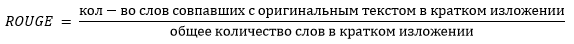  
Существует несколько разновидностей метрик ROUGE, к ним можно отнести метрику ROUGE-1, которая основана на совпадении отдельных слов в оригинальном и сгенерированном тексте. ROUGE-2 учитывает совпадение словосочетаний из двух слов (биграмм). ROUGE-L – оценивает самую длинную последовательность совпавших слов.  
https://newtechaudit.ru/mozhno-li-nauchit-model-ponimat-soderzhanie-teksta/

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) – серия метрик, предложенная Chin-Yew Lin в 2004 для оценки качества решения задачи суммаризации текста.

Как и BLEU, ROUGE основаны на подсчете совпадений слов и словосочетаний в машинном переводе и в эталоне. Но для ROUGE считается не только precision, но и recall, а также параметр F1. Это позволяет обойтись без штрафа за краткость.

Разные метрики серии ROUGE различаются количеством слов, для которых ищутся совпадения:
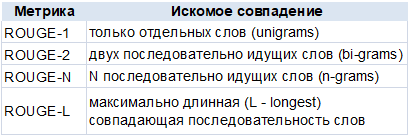

In [ ]:
rouge = evaluate.load("rouge")

## Функция вычисления метрик Rouge

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

## Train with trainer from HuggingFace

In [ ]:
# model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model = MT5ForConditionalGeneration.from_pretrained(CHEKPOINT)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=PUSH_TO_HUB,
    hub_token=HUB_TOKEN,
    hub_private_repo=HUB_PRIVATE_REPO,
    auto_find_batch_size=AUTO_FIND_BATCH_SIZE,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.065100,0.667772,0.064900,0.015200,0.064200,0.064700,18.966200
2,0.783800,0.615860,0.116900,0.031000,0.114700,0.116100,19.000000
3,0.705600,0.589317,0.116100,0.032200,0.114800,0.116000,19.000000
4,0.637200,0.565602,0.123100,0.033100,0.121500,0.123400,19.000000
5,0.646300,0.558098,0.115400,0.029300,0.113400,0.115200,19.000000
6,0.608600,0.556514,0.115400,0.027600,0.113100,0.114700,19.000000
7,0.626000,0.558042,0.117400,0.027600,0.115500,0.117000,19.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=7420, training_loss=1.0884956298170063, metrics={'train_runtime': 5586.9343, 'train_samples_per_second': 1.328, 'train_steps_per_second': 1.328, 'total_flos': 5982488451523584.0, 'train_loss': 1.0884956298170063, 'epoch': 7.0})

In [ ]:
# Сохраняем модель
model.save_pretrained(SAVE_DIR)

## Inference test

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
OUTPUT_DIR='my_lenta_model_ru_mt5-base_7_epochs'
# tokenizer = AutoTokenizer.from_pretrained(LOGIN+'/'+OUTPUT_DIR, token=HUB_TOKEN)
model = AutoModelForSeq2SeqLM.from_pretrained(LOGIN+'/'+OUTPUT_DIR, token=HUB_TOKEN)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [ ]:
test_data = pd.DataFrame(tokenized_dataset['test']).sample(5)
for i, row in test_data.iterrows():
  text = row['Text']
  description = row['Description']
  inputs = tokenizer(text, return_tensors="pt").input_ids
  outputs = model.generate(inputs, max_new_tokens=MAX_NEW_TOKENS, do_sample=False)
  result = tokenizer.decode(outputs[0], skip_special_tokens=True)
  print(f'Оригинальное резюме: "{description}"\n\nРезюме от нейросети: "{result}"\n\nИсходный текст: "{text}"')
  print('----------------------------------------------------')
  pass

Token indices sequence length is longer than the specified maximum sequence length for this model (1152 > 1024). Running this sequence through the model will result in indexing errors


Оригинальное резюме: " Чемпион UFC Джон Джонс ответил россиянину Исламу Махачеву, раскритиковавшему рейтинги промоушена. «Тяжела голова, носящая корону. Я хотел бы призвать молодых бойцов бить некоторые из моих рекордов вместо того, чтобы говорить. Вот это будет круто», — заявил Джонс. Он отметил, что критика его достижений естественна. "

Резюме от нейросети: "В октябре 2021 года, после победы Махачева над новозеландцем Дэном Хукером, Макгрегор тоже оскорбил россиянина. «Тяжела голова, носящая корону. Я хотел бы призвать молодых бойцов бить некоторые из моих рекордов вместо того, чтобы говорить. Вот это будет круто», — заявил Джонс."

Исходный текст: "Американский чемпион Абсолютного бойцовского чемпионата (UFC)  Джон Джонс  ответил российскому бойцу смешанного стиля (MMA)  Исламу Махачеву , раскритиковавшему рейтинги промоушена. Спортсмен высказался в социальной сети  X  (бывшее название Twitter). «Тяжела голова, носящая корону. Я хотел бы призвать молодых бойцов бить некоторые из мо